In [71]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
from ultralytics import YOLO
import json
import supervision as sv
import numpy as np
import matplotlib.pyplot as plt

model = YOLO('yolov8s.pt')
model.to('cuda')

frame_dir = "C:\\Users\\mihir\\Videos\\extract-turkey\\final-subset"
depth_dir = "C:\\Users\\mihir\\Videos\\extract-turkey\\MeshroomCache\\DepthMapFilter\\latest"
sfm = "C:\\Users\\mihir\\Videos\\extract-turkey\\MeshroomCache\\SfMTransform\\cameras.sfm"
views = {}
poses = {}

with open(sfm, 'r') as f:
    data = json.load(f)
    intrinsic = data['intrinsics'][0]
    view_data = data['views']
    for camera in view_data:
        views[camera['frameId']] = camera
    
    poses_data = data['poses']

    for pose in poses_data:
        poses[pose['poseId']] = pose
    


In [72]:
frames = os.listdir(frame_dir)
frame = frames[61]
idx = frame[5:-4]
view = views[idx]
pose = poses[view['poseId']]['pose']

img = cv2.imread(os.path.join(frame_dir, frame))
depth = cv2.imread(os.path.join(depth_dir, view['poseId']  + '_depthMap.exr'), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

results = model(img,imgsz=960)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]
detections = detections[detections.confidence > 0.3]



0: 544x960 5 persons, 10 cars, 2 buss, 3 trucks, 23.5ms
Speed: 8.0ms preprocess, 23.5ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 960)


[     928.84      589.37      950.07      640.55]
[464, 475] [294, 320]
(26, 11)


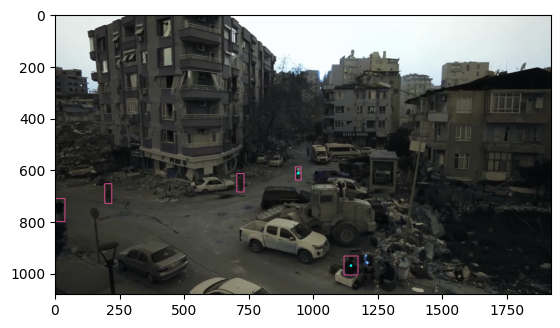

In [77]:
xyxy = detections.xyxy[3]
print(xyxy)
x = [xyxy[0] * 1/2, xyxy[2] * 1/2]
x = [int(x[0]), int(x[1])]

y = [xyxy[1] * 1/2, xyxy[3] * 1/2]
y = [int(y[0]), int(y[1])]
center = [(xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2]

box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=2, text_scale=2)
#labels = [f"{model.names[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=img, detections=detections, skip_label=True)
frame = cv2.circle(frame, (int(center[0]), int(center[1])), 5, (0, 255, 255), -1)
%matplotlib inline
plt.imshow(frame)
print(x,y)
depth_subset = depth[y[0]:y[1], x[0]:x[1]]
print(depth_subset.shape)

# cropped = sv.crop_image(img, xyxy=xyxy)
# plt.imshow(cropped)

In [78]:

# Camera intrinsic parameters
fx = float(intrinsic['focalLength'])
fy = float(intrinsic['focalLength'])
cx = float(intrinsic['principalPoint'][0])
cy = float(intrinsic['principalPoint'][1])

# Camera extrinsic parameters
rotation_matrix = np.array([
    [float(x) for x in pose['transform']['rotation'][:3]],
    [float(x) for x in pose['transform']['rotation'][3:6]],
    [float(x) for x in pose['transform']['rotation'][6:]]
])
translation_vector = np.array([float(x) for x in pose['transform']['center']])

# 3D point in camera coordinates (image coordinates)
image_point = np.array([center[0], center[1], 1.0])

# Normalize image coordinates
normalized_image_point = np.linalg.inv(np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])) @ image_point

# Calculate world coordinates
world_point = np.linalg.inv(rotation_matrix) @ np.linalg.inv(np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])) @ normalized_image_point - translation_vector

print("World coordinates:", world_point / 100)


World coordinates: [   0.066866    0.037752    0.025759]
